# Installs & Imports

In [1]:
!pip install -q prophet ThymeBoost statsforecast lightgbm dask[dataframe]

In [2]:
import os
import sys
import contextlib
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# Suppress logging from Prophet and CmdStanPy
logging.getLogger('prophet').disabled = True
logging.getLogger('cmdstanpy').disabled = True
os.environ["CMDSTANPY_VERBOSITY"] = "error"

@contextlib.contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull.
    This suppresses all prints and logging messages sent to stdout/stderr.
    """
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

from prophet import Prophet
from ThymeBoost import ThymeBoost as tb
from statsforecast.models import AutoMFLES
from statsforecast import StatsForecast
from statsforecast.utils import ConformalIntervals
import lightgbm as lgb

# Data Loading

In [3]:
def load_data(url):
    df = pd.read_csv(url)
    df['ds'] = pd.to_datetime(df['ds'])
    return df

# Load the data
data_url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
df = load_data(data_url)
df.head(10)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
5,2007-12-15,7.783641
6,2007-12-16,8.414052
7,2007-12-17,8.829226
8,2007-12-18,8.382518
9,2007-12-19,8.069655


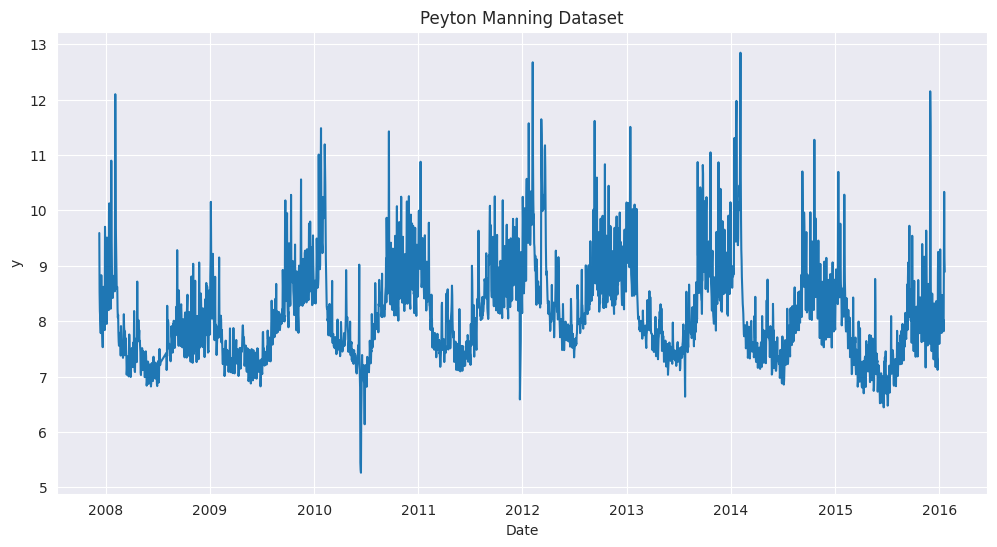

In [4]:
def visualize_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], markersize=1, linestyle='-')  # plot the time series data
    plt.title('Peyton Manning Dataset')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.show()

# Visualize the loaded data
visualize_data(df)

In [5]:
# Dataset info
print("Dataset Information:")
print(df.info())
print("\nSummary Statistics:")
display(df['y'].describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2905 non-null   datetime64[ns]
 1   y       2905 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.5 KB
None

Summary Statistics:


,y
count,2905.000000
mean,8.138958
std,0.845957
min,5.262690
25%,7.514800
50%,7.997999
75%,8.580168
max,12.846747


# Data Preparation

In [6]:
# def split_data(df, out_sample):
#     df = df.sort_values('ds').reset_index(drop=True)
#     train_df = df.iloc[:-out_sample].copy()
#     test_df  = df.iloc[-out_sample:].copy()
#     return train_df, test_df

# # Set out_sample for splitting
# out_sample = 2 * 365
# train_df, test_df = split_data(df, out_sample)

# print("Training period:", train_df['ds'].min(), "to", train_df['ds'].max())
# print("Test period:", test_df['ds'].min(), "to", test_df['ds'].max())

# # Use the test set's dates as the forecast index
# test_dates = test_df['ds'].reset_index(drop=True)
# print("Length of test_dates:", len(test_dates))

In [7]:
def split_data_by_date(df, split_date):
    """
    Split the data using a specific split_date. All rows with ds < split_date go into train_df,
    and rows with ds >= split_date go into test_df.
    """
    df = df.sort_values('ds').reset_index(drop=True)
    train_df = df[df['ds'] < split_date].copy()
    test_df  = df[df['ds'] >= split_date].copy()
    return train_df, test_df

# Specify the split date
split_date = pd.to_datetime('2014-01-18')
train_df, test_df = split_data_by_date(df, split_date)

print("Training period:", train_df['ds'].min(), "to", train_df['ds'].max())
print("Test period:", test_df['ds'].min(), "to", test_df['ds'].max())

print("\nLength of training period:", len(train_df))
print("Length of test period:", len(test_df))

Training period: 2007-12-10 00:00:00 to 2014-01-17 00:00:00
Test period: 2014-01-18 00:00:00 to 2016-01-20 00:00:00

Length of training period: 2175
Length of test period: 730


In [8]:
# Add exogenous features: day-of-week (dow) and month
for d in [train_df, test_df]:
    d['dow'] = d['ds'].dt.dayofweek + 1  # Monday=1, Sunday=7
    d['month'] = d['ds'].dt.month

display(train_df.head())
print("\n")
display(test_df.head())

,ds,y,dow,month
0,2007-12-10,9.590761,1,12
1,2007-12-11,8.519590,2,12
2,2007-12-12,8.183677,3,12
3,2007-12-13,8.072467,4,12
4,2007-12-14,7.893572,5,12


,ds,y,dow,month
2175,2014-01-18,9.434683,6,1
2176,2014-01-19,11.503622,7,1
2177,2014-01-20,11.976779,1,1
2178,2014-01-21,10.542574,2,1
2179,2014-01-22,10.004283,3,1


In [9]:
# Use the test set's ds column as the forecast index
test_dates = test_df['ds'].reset_index(drop=True)
print("Length of test_dates:", len(test_dates))

Length of test_dates: 730


# Model Fitting

In [10]:
def bootstrap_intervals(forecast, residuals, n_bootstrap=1000, alpha=0.05):
    """
    Generate bootstrap forecast samples by randomly adding sampled residuals.
    Returns lower and upper prediction intervals.
    """
    n_forecast = len(forecast)
    boot_samples = np.zeros((n_bootstrap, n_forecast))
    for i in range(n_bootstrap):
        sampled_resids = np.random.choice(residuals, size=n_forecast, replace=True)
        boot_samples[i, :] = forecast + sampled_resids
    lower = np.percentile(boot_samples, 100 * alpha / 2, axis=0)
    upper = np.percentile(boot_samples, 100 * (1 - alpha / 2), axis=0)
    return lower, upper

## Prophet

In [11]:
def fit_and_forecast_prophet(
        train_df,
        test_dates,
        residual_correction=False,
        custom_interval=False,
        n_bootstrap=1000,
        alpha=0.05
):
    model = Prophet()
    model.add_regressor('dow')
    model.add_regressor('month')

    model.fit(train_df)

    # Build future DataFrame using test_dates
    future = pd.DataFrame({'ds': test_dates})
    future['dow'] = future['ds'].dt.dayofweek + 1
    future['month'] = future['ds'].dt.month

    forecast = model.predict(future)

    # Keep only desired columns
    base_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)

    if residual_correction:
        train_forecast = model.predict(train_df)
        train_df = train_df.copy()
        train_df['resid'] = train_df['y'] - train_forecast['yhat']

        X_train = train_df[['dow', 'month']]
        y_train = train_df['resid']

        lgb_reg = lgb.LGBMRegressor(verbose=-1)
        lgb_reg.fit(X_train, y_train)

        X_test = future[['dow', 'month']]
        resid_corr = lgb_reg.predict(X_test)
        base_forecast['yhat'] = base_forecast['yhat'] + resid_corr
        base_forecast['yhat_lower'] = base_forecast['yhat_lower'] + resid_corr
        base_forecast['yhat_upper'] = base_forecast['yhat_upper'] + resid_corr

    if custom_interval:
        # Use bootstrapping to compute custom prediction intervals
        # Use in-sample residuals as reference
        # If residual correction is used, use the residuals computed above
        if residual_correction:
            resid_ref = train_df['resid'].values
        else:
            resid_ref = (train_df['y'] - train_df['y'].shift(1)).dropna().values

        lower, upper = bootstrap_intervals(
            base_forecast['yhat'].values,
            resid_ref,
            n_bootstrap=n_bootstrap,
            alpha=alpha
        )

        base_forecast['yhat_lower'] = lower
        base_forecast['yhat_upper'] = upper

    return base_forecast.reset_index(drop=True)

In [12]:
# Prophet
prophet_forecast_base = fit_and_forecast_prophet(
    train_df,
    test_dates,
    residual_correction=False,
    custom_interval=False,
    n_bootstrap=1000,
    alpha=0.05
)
print("Prophet forecast preview:")
display(prophet_forecast_base.head())
print("\n")
display(prophet_forecast_base.tail())

Prophet forecast preview:


,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,8.915830,8.260662,9.494689
1,2014-01-19,9.296913,8.666239,9.949144
2,2014-01-20,9.565400,8.987030,10.226362
3,2014-01-21,9.345451,8.732746,9.973933
4,2014-01-22,9.175351,8.588918,9.826558


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,8.797178,7.377098,10.183174
726,2016-01-17,9.177300,7.760031,10.543992
727,2016-01-18,9.445375,8.070255,10.870586
728,2016-01-19,9.225728,7.807858,10.680280
729,2016-01-20,9.056798,7.660086,10.557616


In [13]:
# Prophet with residual correction and custom prediction interval
prophet_forecast_resid = fit_and_forecast_prophet(
    train_df,
    test_dates,
    residual_correction=True,
    custom_interval=True,
    n_bootstrap=1000,
    alpha=0.05
)
print("Prophet forecast preview:")
display(prophet_forecast_resid.head())
print("\n")
display(prophet_forecast_resid.tail())

Prophet forecast preview:


,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,8.826052,8.128877,10.031557
1,2014-01-19,9.600793,8.919922,10.902831
2,2014-01-20,9.887525,9.166826,11.372439
3,2014-01-21,9.195326,8.498299,10.382023
4,2014-01-22,8.987518,8.260576,10.281651


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,8.707400,8.026529,9.775579
726,2016-01-17,9.481180,8.797455,10.775983
727,2016-01-18,9.767500,9.074715,11.017144
728,2016-01-19,9.075602,8.329829,10.211310
729,2016-01-20,8.868966,8.188101,10.315129


## ThymeBoost

In [14]:
def fit_and_forecast_thymeboost(
        train_df,
        test_dates,
        residual_correction=False,
        custom_interval=False,
        n_bootstrap=1000,
        alpha=0.05
):
    X_train = train_df[['dow', 'month']].reset_index(drop=True)

    model = tb.ThymeBoost(verbose=0, n_rounds=None)
    output = model.fit(
        train_df['y'].values,
        seasonal_period=[365],
        trend_estimator=['lbf'],
        seasonal_estimator=['fourier'],
        exogenous_estimator=['decision_tree'],
        n_changepoints=25,
        exogenous=X_train
    )

    horizon = len(test_dates)

    # Build exogenous features for test set
    X_test = pd.DataFrame({
        'dow': pd.to_datetime(test_dates).dt.dayofweek + 1,
        'month': pd.to_datetime(test_dates).dt.month
    })

    predicted_output = model.predict(output, horizon, future_exogenous=X_test)

    base_preds = predicted_output['predictions']
    lower_preds = predicted_output['predicted_lower']
    upper_preds = predicted_output['predicted_upper']

    if residual_correction:
        naive_preds = train_df['y'].shift(1)
        resid = (train_df['y'] - naive_preds).dropna().values

        X_train_resid = X_train.iloc[1:].values
        X_test_resid = X_test[['dow', 'month']].values

        lgb_reg = lgb.LGBMRegressor(verbose=-1)
        lgb_reg.fit(X_train_resid, resid)

        resid_corr = lgb_reg.predict(X_test_resid)
        base_preds = base_preds + resid_corr
        lower_preds = lower_preds + resid_corr
        upper_preds = upper_preds + resid_corr

    if custom_interval:
        ref_resid = resid if residual_correction else (train_df['y'] - train_df['y'].shift(1)).dropna().values

        lower, upper = bootstrap_intervals(
            base_preds,
            ref_resid,
            n_bootstrap=n_bootstrap,
            alpha=alpha
        )
    else:
        # Use ThymeBoost's native prediction intervals
        lower = lower_preds
        upper = upper_preds

    thymeboost_df = pd.DataFrame({
        'ds': test_dates.to_numpy(),
        'yhat': base_preds,
        'yhat_lower': lower,
        'yhat_upper': upper
    }).reset_index(drop=True)
    return thymeboost_df

In [15]:
# ThymeBoost
thymeboost_forecast_base = fit_and_forecast_thymeboost(
    train_df,
    test_dates,
    residual_correction=False,
    custom_interval=False,
    n_bootstrap=1000,
    alpha=0.05
)
print("ThymeBoost forecast preview:")
display(thymeboost_forecast_base.head())
print("\n")
display(thymeboost_forecast_base.tail())

ThymeBoost forecast preview:


,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,9.214221,8.137191,10.291251
1,2014-01-19,9.492067,8.413550,10.570585
2,2014-01-20,9.705173,8.625168,10.785179
3,2014-01-21,9.540184,8.458692,10.621677
4,2014-01-22,9.301260,8.218280,10.384240


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,10.267456,8.111919,12.422994
726,2016-01-17,10.547622,8.390597,12.704646
727,2016-01-18,10.762713,8.604201,12.921225
728,2016-01-19,10.599417,8.439417,12.759416
729,2016-01-20,10.361961,8.200474,12.523449


In [16]:
# ThymeBoost with residual correction and custom prediction interval
thymeboost_forecast_resid = fit_and_forecast_thymeboost(
    train_df,
    test_dates,
    residual_correction=True,
    custom_interval=True,
    n_bootstrap=1000,
    alpha=0.05
)
print("ThymeBoost forecast preview:")
display(thymeboost_forecast_resid.head())
print("\n")
display(thymeboost_forecast_resid.tail())

ThymeBoost forecast preview:


,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,9.208113,8.264463,10.292069
1,2014-01-19,10.276209,9.133599,11.547106
2,2014-01-20,9.967466,8.923626,11.025704
3,2014-01-21,8.840799,7.873462,10.228946
4,2014-01-22,9.103152,8.173939,10.194984


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,10.261349,9.255302,11.556450
726,2016-01-17,11.331763,10.244353,12.406200
727,2016-01-18,11.025005,10.096158,12.132033
728,2016-01-19,9.900031,8.884216,11.091755
729,2016-01-20,10.163854,9.020282,11.207449


## AutoMFLES

In [17]:
def fit_and_forecast_automfles(
        train_df,
        test_df,
        residual_correction=False,
        custom_interval=False,
        n_bootstrap=1000,
        alpha=0.05
):
    # Add a unique identifier required by StatsForecast
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df['unique_id'] = 'ts1'
    test_df['unique_id'] = 'ts1'

    # Arrange training and test sets
    X_train = train_df[['unique_id', 'ds', 'y', 'dow', 'month']]
    X_test = test_df[['unique_id', 'ds', 'dow', 'month']]

    horizon = len(test_df)
    prediction_intervals = ConformalIntervals(h=horizon, n_windows=2)

    models = [AutoMFLES(
        season_length=[365],
        test_size=horizon,
        prediction_intervals=prediction_intervals,
        metric='smape'
    )]
    sf = StatsForecast(models=models, freq='D', n_jobs=-1)

    # Forecast
    horizon = len(test_df)
    level = int((1.0 - alpha) * 100)

    fcst = sf.forecast(
        df=X_train,
        h=horizon,
        X_df=X_test,
        level=[level],
        fitted=True
    )

    base_preds = fcst['AutoMFLES'].values
    lower_preds = fcst['AutoMFLES-lo-95'].values
    upper_preds = fcst['AutoMFLES-hi-95'].values

    if residual_correction:
        fitted = sf.forecast_fitted_values()['AutoMFLES'].values
        resid = X_train['y'].values - fitted

        reg = lgb.LGBMRegressor(verbose=-1)
        reg.fit(X_train[['dow', 'month']], resid)

        resid_corr = reg.predict(X_test[['dow', 'month']])

        base_preds = base_preds + resid_corr
        lower_preds = lower_preds + resid_corr
        upper_preds = upper_preds + resid_corr

    if custom_interval:
        ref_resid = resid if residual_correction else (X_train['y'] - X_train['y'].shift(1)).dropna().values

        lower, upper = bootstrap_intervals(
            base_preds,
            ref_resid,
            n_bootstrap=n_bootstrap,
            alpha=alpha
        )
    else:
        # Use StatsForecast's native prediction intervals
        lower = lower_preds
        upper = upper_preds

    automfles_df = pd.DataFrame({
        'ds': X_test['ds'],
        'yhat': base_preds,
        'yhat_lower': lower,
        'yhat_upper': upper
    }).reset_index(drop=True)
    return automfles_df

In [18]:
# AutoMFLES
automfles_forecast_base = fit_and_forecast_automfles(
    train_df,
    test_df,
    residual_correction=False,
    custom_interval=False,
    n_bootstrap=1000,
    alpha=0.05
)
print("AutoMFLES forecast preview:")
display(automfles_forecast_base.head())
print("\n")
display(automfles_forecast_base.tail())

AutoMFLES forecast preview:


,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,9.190921,8.250058,10.131785
1,2014-01-19,9.143971,8.996815,9.291126
2,2014-01-20,9.333522,8.994587,9.672456
3,2014-01-21,9.286074,8.688270,9.883878
4,2014-01-22,9.240336,8.951986,9.528687


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,9.245602,7.668820,10.822384
726,2016-01-17,9.216574,8.843235,9.589914
727,2016-01-18,9.420817,9.193119,9.648516
728,2016-01-19,9.380596,9.082420,9.678772
729,2016-01-20,9.336787,7.590819,11.082754


In [19]:
# AutoMFLES with residual correction and custom prediction interval
automfles_forecast_resid = fit_and_forecast_automfles(
    train_df,
    test_df,
    residual_correction=True,
    custom_interval=True,
    n_bootstrap=1000,
    alpha=0.05
)
print("AutoMFLES forecast preview:")
display(automfles_forecast_resid.head())
print("\n")
display(automfles_forecast_resid.tail())

AutoMFLES forecast preview:


,ds,yhat,yhat_lower,yhat_upper
0,2014-01-18,9.170635,8.319962,10.643296
1,2014-01-19,9.747622,8.903311,10.880781
2,2014-01-20,9.965661,9.131001,11.497063
3,2014-01-21,9.371945,8.569812,10.457643
4,2014-01-22,9.164653,8.395990,10.713660


,ds,yhat,yhat_lower,yhat_upper
725,2016-01-16,9.225315,8.388425,10.697977
726,2016-01-17,9.820226,8.985564,11.216826
727,2016-01-18,10.052957,9.208743,11.702637
728,2016-01-19,9.466466,8.608429,10.799841
729,2016-01-20,9.261104,8.411463,10.773811


# Metrics Evaluation

In [20]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

def mae(y, y_pred):
    return np.mean(np.abs(y - y_pred))

def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / np.where(y == 0, 1e-8, y))) * 100

def smape(y, y_pred):
    return 100 / len(y) * np.sum(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred) + 1e-8))

def wmape(y, y_pred):
    return 100 * np.sum(np.abs(y - y_pred)) / (np.sum(np.abs(y)) + 1e-8)

In [21]:
def compute_model_metrics(eval_df, model_label):
    y_true = eval_df['y'].values
    y_pred = eval_df['yhat'].values
    return {
        'Model': model_label,
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'MAPE': mape(y_true, y_pred),
        'sMAPE': smape(y_true, y_pred),
        'wMAPE': wmape(y_true, y_pred)
    }

In [22]:
# Normalize ds columns in all forecast dataframes for proper merging and evaluation
eval_df = test_df[['ds', 'y']].reset_index(drop=True)
eval_df['ds'] = pd.to_datetime(eval_df['ds']).dt.normalize()

for df_model in [prophet_forecast_base, prophet_forecast_resid,
                 thymeboost_forecast_base, thymeboost_forecast_resid,
                 automfles_forecast_base, automfles_forecast_resid]:
    df_model['ds'] = pd.to_datetime(df_model['ds']).dt.normalize()

display(eval_df.head())
print("\nTest set ds range:", eval_df['ds'].min(), "to", eval_df['ds'].max())

,ds,y
0,2014-01-18,9.434683
1,2014-01-19,11.503622
2,2014-01-20,11.976779
3,2014-01-21,10.542574
4,2014-01-22,10.004283



Test set ds range: 2014-01-18 00:00:00 to 2016-01-20 00:00:00


In [23]:
# Merge forecasts
prophet_eval_base = eval_df.merge(prophet_forecast_base[['ds', 'yhat']], on='ds', how='left')
prophet_eval_resid = eval_df.merge(prophet_forecast_resid[['ds', 'yhat']], on='ds', how='left')

thymeboost_eval_base = eval_df.merge(thymeboost_forecast_base[['ds', 'yhat']], on='ds', how='left')
thymeboost_eval_resid = eval_df.merge(thymeboost_forecast_resid[['ds', 'yhat']], on='ds', how='left')

automfles_eval_base = eval_df.merge(automfles_forecast_base[['ds', 'yhat']], on='ds', how='left')
automfles_eval_resid = eval_df.merge(automfles_forecast_resid[['ds', 'yhat']], on='ds', how='left')

In [24]:
# Compute metrics
metrics = []
metrics.append(compute_model_metrics(prophet_eval_base, 'Prophet Base'))
metrics.append(compute_model_metrics(prophet_eval_resid, 'Prophet Residual'))
metrics.append(compute_model_metrics(thymeboost_eval_base, 'ThymeBoost Base'))
metrics.append(compute_model_metrics(thymeboost_eval_resid, 'ThymeBoost Residual'))
metrics.append(compute_model_metrics(automfles_eval_base, 'AutoMFLES Base'))
metrics.append(compute_model_metrics(automfles_eval_resid, 'AutoMFLES Residual'))

# Display metrics DataFrame
metrics_df = pd.DataFrame(metrics)
print("Forecast Error Metrics:")
display(metrics_df)

Forecast Error Metrics:


,Model,RMSE,MAE,MAPE,sMAPE,wMAPE
0,Prophet Base,0.623878,0.499587,6.287828,6.118931,6.292725
1,Prophet Residual,0.595968,0.480015,6.039184,5.880895,6.046196
2,ThymeBoost Base,1.337858,1.195507,15.403813,14.089643,15.058441
3,ThymeBoost Residual,1.358575,1.198651,15.404440,14.064457,15.098038
4,AutoMFLES Base,0.753467,0.633143,8.033377,7.720482,7.974980
5,AutoMFLES Residual,0.735335,0.620161,7.884554,7.553016,7.811460


# Forecast Plotting

In [25]:
def plot_model_forecast(eval_df, forecast_df, model_label, ax):
    ax.plot(eval_df['ds'], eval_df['y'], label='Actual', color='black')
    ax.plot(forecast_df['ds'], forecast_df['yhat'], label='Predicted')
    ax.fill_between(forecast_df['ds'],
                    forecast_df['yhat_lower'],
                    forecast_df['yhat_upper'],
                    alpha=0.2, label='Prediction Interval')
    ax.set_title(f'{model_label} Forecast vs. Actual')
    ax.legend(fontsize=8)

In [26]:
def plot_all_forecasts(eval_df, forecasts_dict):
    n = len(forecasts_dict)
    fig, axs = plt.subplots(n, 1, figsize=(14, 4*n), sharex=True)
    if n == 1:
        axs = [axs]
    for ax, (label, forecast_df) in zip(axs, forecasts_dict.items()):
        plot_model_forecast(eval_df, forecast_df, label, ax)
    axs[-1].set_xlabel('Date')
    plt.show()

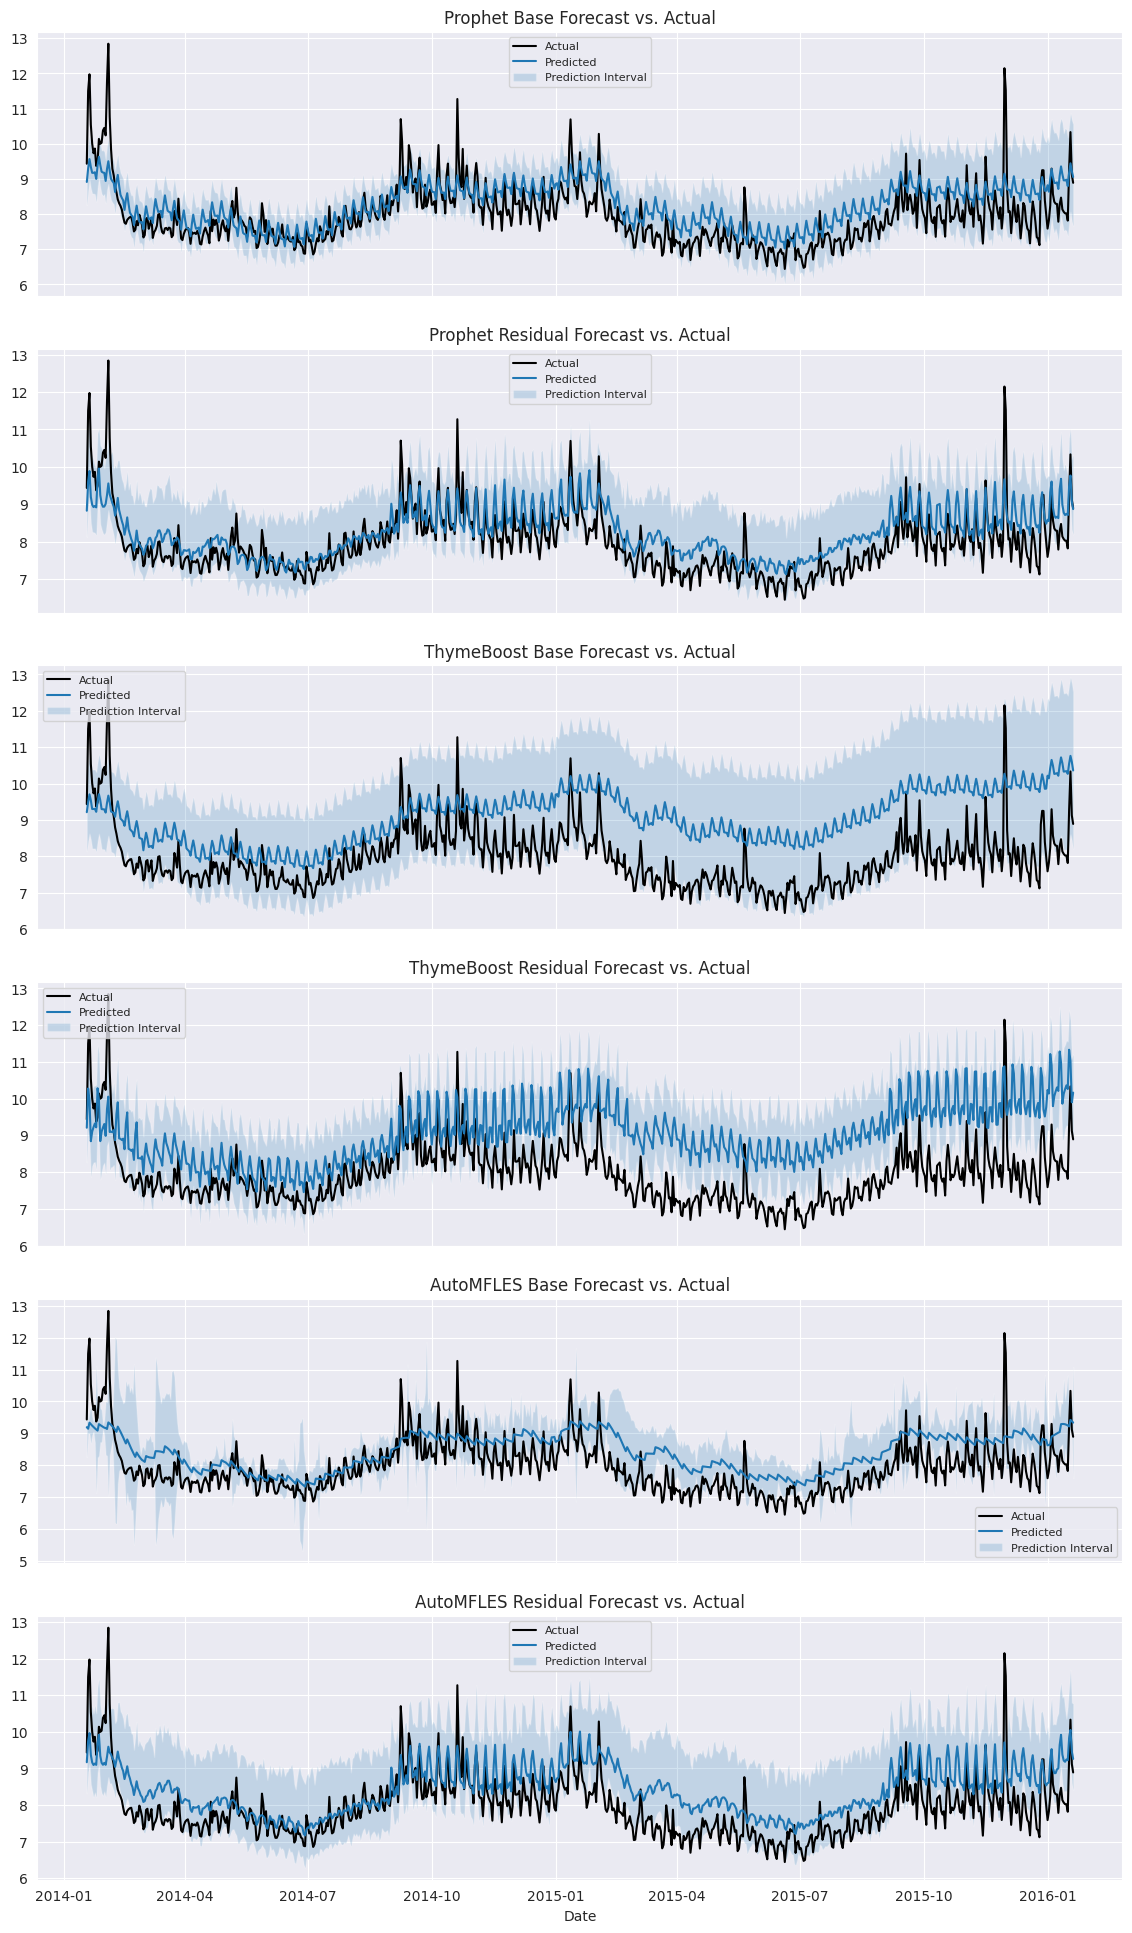

In [27]:
# Plot all forecasts versus the actual test data
forecasts_dict = {
    'Prophet Base': prophet_forecast_base,
    'Prophet Residual': prophet_forecast_resid,
    'ThymeBoost Base': thymeboost_forecast_base,
    'ThymeBoost Residual': thymeboost_forecast_resid,
    'AutoMFLES Base': automfles_forecast_base,
    'AutoMFLES Residual': automfles_forecast_resid
}
plot_all_forecasts(eval_df, forecasts_dict)